In [166]:
pip install pandas imbalanced-learn scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [167]:
pip install numpy matplotlib seaborn scikit-learn faker mysql-connector-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
fake = Faker()

In [169]:
interaction_data = create_interaction_data(1000, existing_customer_ids)
save_to_mysql(interaction_data, 'interactions')

In [170]:
# Loan Data Creation

def create_loan_data(n):
    data = {
        'customer_id': [fake.uuid4() for _ in range(n)],
        'age': [fake.random_int(min=18, max=70) for _ in range(n)],
        'income': [fake.random_int(min=20000, max=100000) for _ in range(n)],
        'credit_score': [fake.random_int(min=300, max=850) for _ in range(n)],
        'loan_amount': [fake.random_int(min=5000, max=50000) for _ in range(n)],
        'interest_rate': [round(fake.random_number(digits=2), 2) for _ in range(n)],
        'loan_term': [fake.random_int(min=12, max=60) for _ in range(n)],
        'repayment_status': [fake.random_int(min=0, max=1) for _ in range(n)]
    }
    return pd.DataFrame(data)


In [171]:
#Create Transaction Data

def create_transaction_data(n, existing_customer_ids):
    data = {
        'customer_id': [fake.random.choice(existing_customer_ids) for _ in range(n)],  # Use existing customer IDs
        'transaction_amount': [round(fake.random_number(digits=4), 2) for _ in range(n)],
        'transaction_type': [fake.random_element(elements=('deposit', 'withdrawal')) for _ in range(n)],
        'transaction_date': [fake.date_this_decade() for _ in range(n)]
    }
    return pd.DataFrame(data)


In [172]:
#Create Interaction Data

def create_interaction_data(n, existing_customer_ids):
    data = {
        'customer_id': [fake.random_element(elements=existing_customer_ids) for _ in range(n)],
        'product_id': [fake.uuid4() for _ in range(n)],
        'interaction_type': [fake.random_element(elements=('purchased', 'viewed', 'clicked')) for _ in range(n)],
        'interaction_date': [fake.date_this_decade() for _ in range(n)]
    }
    return pd.DataFrame(data)


In [173]:
import mysql.connector

def save_to_mysql(df, table_name, clear_existing=False):
    
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='Arunrajesh@1997',
        database='banking_db'
    )
    cursor = conn.cursor()

    for _, row in df.iterrows():
            if table_name == 'loans':
                cursor.execute("""
                    INSERT INTO loans (customer_id, age, income, credit_score, loan_amount, interest_rate, loan_term, repayment_status)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                """, tuple(row))
            elif table_name == 'transactions':
                cursor.execute("""
                    INSERT INTO transactions (customer_id, transaction_amount, transaction_type, transaction_date)
                    VALUES (%s, %s, %s, %s)
                """, (row['customer_id'], row['transaction_amount'], row['transaction_type'], row['transaction_date']))
            elif table_name == 'interactions':
                cursor.execute("""
                    INSERT INTO interactions (customer_id, product_id, interaction_type, interaction_date)
                    VALUES (%s, %s, %s, %s)
                """, tuple(row))
    conn.commit()
    cursor.close()
    conn.close()


In [174]:
loan_data = create_loan_data(10000)
save_to_mysql(loan_data, 'loans')

In [175]:
existing_customer_ids = loan_data['customer_id'].tolist()

In [176]:
transaction_data = create_transaction_data(10000, existing_customer_ids)
save_to_mysql(transaction_data, 'transactions')

In [177]:
interaction_data = create_interaction_data(10000, existing_customer_ids)
save_to_mysql(interaction_data, 'interactions')

In [178]:
def load_from_mysql(query):
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='Arunrajesh@1997',
        database='banking_db'
    )
    df = pd.read_sql(query, conn)
    conn.close()
    return df

loan_data = load_from_mysql("SELECT * FROM loans")
transaction_data = load_from_mysql("SELECT * FROM transactions")
interaction_data = load_from_mysql("SELECT * FROM interactions")

C:\Users\arunr\AppData\Local\Temp\ipykernel_18152\2844314796.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [179]:
print(loan_data.shape)

(131000, 8)


In [180]:
print(loan_data.head())


                            customer_id  age  income  credit_score  \
0  000007bf-254a-4c96-b75d-970ede6dfd64   43   87619           831   
1  00000ce9-e166-4eb0-8ecd-6ffe2c38ad65   46   79344           355   
2  000099c8-6604-4a2d-a7a2-1879e0e1a54f   37   23449           478   
3  0000a671-3679-463a-8e81-c7d86624676a   24   29602           509   
4  0000d31b-b917-45c1-aad6-78128834b00e   48   72614           563   

   loan_amount  interest_rate  loan_term  repayment_status  
0        14893           56.0         24                 0  
1        31630           76.0         57                 0  
2        11670           20.0         27                 1  
3        30124           55.0         45                 0  
4        17961           89.0         55                 1  


In [181]:
print(loan_data.describe())

                 age         income   credit_score    loan_amount  \
count  131000.000000  131000.000000  131000.000000  131000.000000   
mean       43.950237   59934.272687     574.887504   27512.093893   
std        15.275287   23101.892663     159.105115   12973.533146   
min        18.000000   20000.000000     300.000000    5000.000000   
25%        31.000000   39914.750000     437.000000   16261.750000   
50%        44.000000   59913.000000     575.000000   27493.500000   
75%        57.000000   79879.000000     713.000000   38738.250000   
max        70.000000  100000.000000     850.000000   50000.000000   

       interest_rate      loan_term  repayment_status  
count  131000.000000  131000.000000     131000.000000  
mean       49.617634      35.961046          0.500893  
std        28.840978      14.152812          0.500001  
min         0.000000      12.000000          0.000000  
25%        25.000000      24.000000          0.000000  
50%        50.000000      36.000000       

In [182]:
print(loan_data.isnull().sum())

customer_id         0
age                 0
income              0
credit_score        0
loan_amount         0
interest_rate       0
loan_term           0
repayment_status    0
dtype: int64


In [183]:
numeric_loan_data = loan_data.select_dtypes(include=[np.number])

In [184]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

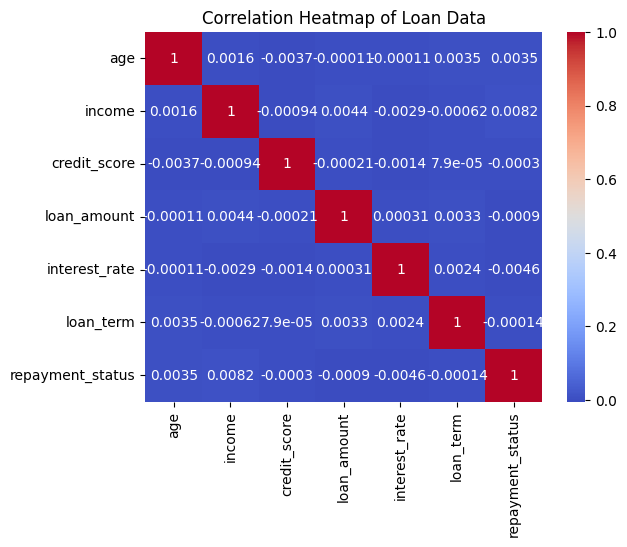

In [185]:
sns.heatmap(numeric_loan_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Loan Data')
plt.show()

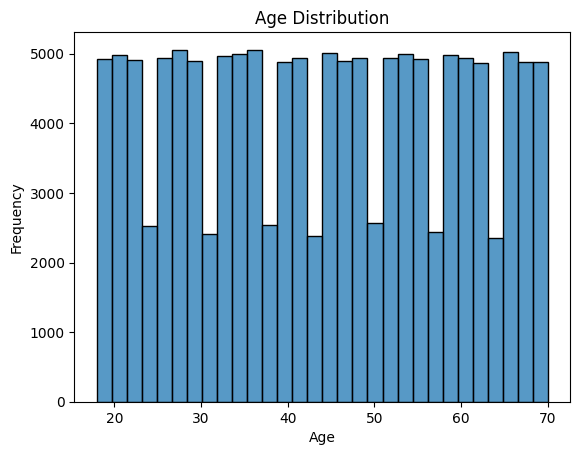

In [186]:
sns.histplot(loan_data['age'], bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

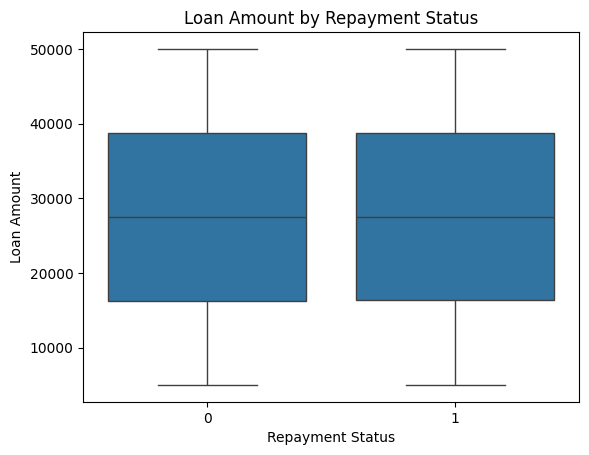

In [187]:
sns.boxplot(x='repayment_status', y='loan_amount', data=loan_data)
plt.title('Loan Amount by Repayment Status')
plt.xlabel('Repayment Status')
plt.ylabel('Loan Amount')
plt.show()

In [188]:
X = loan_data.drop(['repayment_status', 'customer_id'], axis=1)
y = loan_data['repayment_status']

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [191]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_smote)
X_test_poly = poly.transform(X_test)

In [192]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [193]:
log_reg = LogisticRegression()

In [194]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'max_iter': [500]
}

In [195]:
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_smote)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\arunr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arunr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\arunr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\arunr\AppDat

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [500],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga']},
             scoring='f1', verbose=1)

In [196]:
best_log_reg = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}


In [197]:
best_log_reg.fit(X_train_scaled, y_train_smote)
y_pred_log = best_log_reg.predict(X_test_scaled)

In [198]:
def evaluate_model(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"F1-Score: {f1_score(y_true, y_pred)}")
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred)}")

print("\nLogistic Regression Performance:")
evaluate_model(y_test, y_pred_log)


Logistic Regression Performance:
Accuracy: 0.49706106870229005
Precision: 0.500242914979757
Recall: 0.46863384662064783
F1-Score: 0.4839227666157522
ROC-AUC Score: 0.4972423285496263


In [199]:
rf = RandomForestClassifier(random_state=42)

In [202]:
y_pred_rf = best_rf.predict(X_test_scaled)

In [203]:
print("\nRandom Forest Performances:")
evaluate_model(y_test, y_pred_rf)


Random Forest Performances:
Accuracy: 0.5033969465648855
Precision: 0.5066967762030836
Recall: 0.4935902298414625
F1-Score: 0.5000576368876081
ROC-AUC Score: 0.5034594769089006


In [204]:
gb = GradientBoostingClassifier(random_state=42)

In [205]:
y_pred_gb = best_gb.predict(X_test_scaled)

In [206]:
print("\nGradient Boosting Performance:")
evaluate_model(y_test, y_pred_gb)


Gradient Boosting Performance:
Accuracy: 0.5037404580152671
Precision: 0.5066597983663257
Recall: 0.5222635212015474
F1-Score: 0.5143433437920215
ROC-AUC Score: 0.5036223498302428


In [207]:
#Customer Segmentation

# Aggregating transaction data by customer
transaction_agg = transaction_data.groupby('customer_id').agg({
    'transaction_amount': ['sum', 'mean', 'count']
}).reset_index()

In [208]:
transaction_agg.columns = ['customer_id', 'total_amount', 'avg_amount', 'transaction_count']


In [209]:
scaler = StandardScaler()
transaction_scaled = scaler.fit_transform(transaction_agg.drop('customer_id', axis=1))

In [210]:
kmeans = KMeans(n_clusters=3, random_state=42)
transaction_agg['cluster'] = kmeans.fit_predict(transaction_scaled)

In [211]:
sil_score = silhouette_score(transaction_scaled, transaction_agg['cluster'])
db_score = davies_bouldin_score(transaction_scaled, transaction_agg['cluster'])
print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Index: {db_score}')

Silhouette Score: 0.49593935506445364
Davies-Bouldin Index: 0.640928935734913


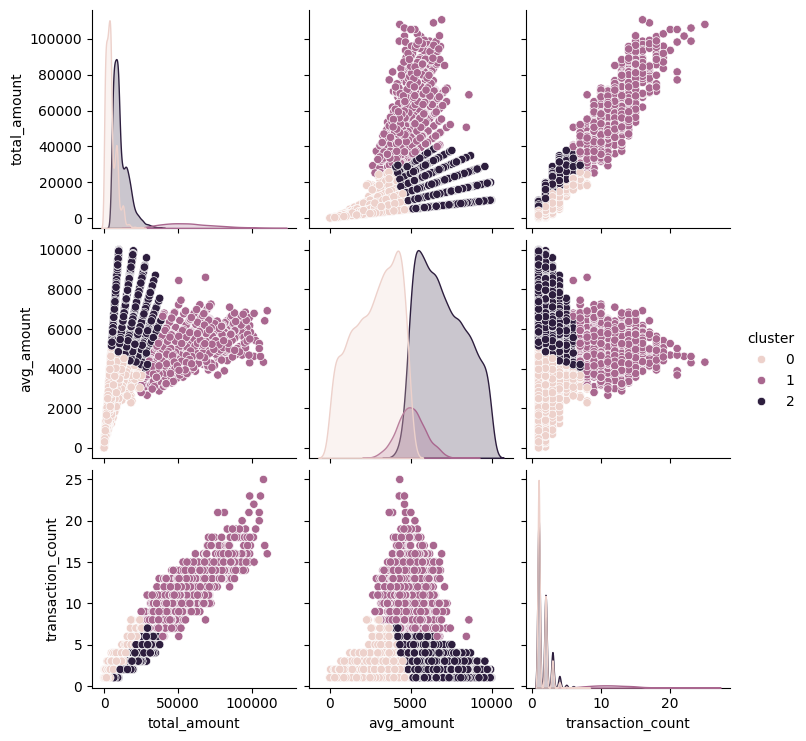

In [212]:
sns.pairplot(transaction_agg, hue='cluster', diag_kind='kde')
#'Customer Segmentation Clusters')
plt.show()

In [213]:
#Recommendation Engine
# Creating customer-product matrix
interaction_matrix = pd.pivot_table(interaction_data, index='customer_id', columns='product_id', aggfunc='size', fill_value=0)

In [214]:
similarity_matrix = cosine_similarity(interaction_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=interaction_matrix.index, columns=interaction_matrix.index)

In [215]:
def recommend_products(customer_id, n_recommendations=5):
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).index[1:n_recommendations + 1]
    return interaction_data[interaction_data['customer_id'].isin(similar_customers)]['product_id'].unique()

In [216]:
print(recommend_products(interaction_data['customer_id'][1]))


['9144d0ae-ff4e-4394-9b42-1d0b7b53f5f3'
 'c778a6ef-3b1c-4ef7-aa0f-eb60477e672e'
 '3653cdb1-4ffb-4a6d-a9cd-5a900e373ed4'
 '5c076f22-df42-45ef-8857-9b8b46b24e6f'
 '3693604d-38ba-4058-bdc3-39f58f23481f'
 '7d2237f1-0fe2-465e-a9f1-c650376f50c5'
 'ab49546d-7c40-4688-9e9d-1856400c629d'
 '0457cbc3-96a2-4138-8827-bce0306bba5f']


In [217]:
def precision_recall_at_k(actual, predicted, k):
    pred_k = predicted[:k]
    true_positives = len(set(actual) & set(pred_k))
    precision = true_positives / k
    recall = true_positives / len(actual) if len(actual) > 0 else 0
    return precision, recall

In [218]:
actual_products = interaction_data[interaction_data['customer_id'] == interaction_data['customer_id'][1]]['product_id'].tolist()
predicted_products = recommend_products(interaction_data['customer_id'][1])
precision, recall = precision_recall_at_k(actual_products, predicted_products, k=5)
print(f'Precision: {precision}, Recall: {recall}')

Precision: 0.0, Recall: 0.0
